## Advanced Multimmodal RAG with Azure AI Search and LlamaIndex
This notebook demonstrates the implementation of a sophisticated Multi-Modal Retrieval-Augmented Generation (RAG) system using Azure AI Search, Azure OpenAI services and LlamaIndex. The system processes both text and images from PDF documents, storing them in Azure Blob Storage and Azure AI Search for efficient retrieval.

**Prerequisites**
- Python 3.9+
- Azure OpenAI Service
- Azure AI Search
- Azure Blob Storage

**Key Features**
- Multi-Modal RAG
  - PDF Processing (Text + Images) via LlamaParse Premium
  - Vector/Hybrid Search with Azure AI Search
  - GPT-4o for multimodal generative experience!

## Setup and Dependencies
First, let's install the required packages:

In [1]:
# ! pip install chainlit
# ! pip install llama-index-vector-stores-azureaisearch==0.3.0
# ! pip install llama-index-core
# ! pip install azure-storage-blob
# ! pip install python-dotenv

## Environment Configuration and Imports

In [2]:
import os
import json
import time
import logging
from copy import deepcopy
from dotenv import load_dotenv
import nest_asyncio
from typing import Optional

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType
import os
import asyncio
from azure.storage.blob.aio import BlobServiceClient
from llama_parse import LlamaParse
import re
from copy import deepcopy
from typing import Dict, List
from llama_index.core.schema import TextNode, MetadataMode
import nest_asyncio
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
# Example usage of MultimodalQueryEngine
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from llama_index.core.vector_stores.types import VectorStoreQueryMode


# Apply nest_asyncio to avoid asyncio errors in notebooks
nest_asyncio.apply()

## (Optional) Initialize Monitoring with Arize Phoenix
Arize Phoenix provides real-time tracing capabilities for LlamaIndex applications.

In [3]:
# import phoenix as px
# import llama_index.core

# px.launch_app()
# llama_index.core.set_global_handler("arize_phoenix")

## Azure OpenAI Configuration
Initialize Azure OpenAI models for embeddings and completion:

In [ ]:
load_dotenv(override=True)

# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
azure_openai_endpoint = f"{AZURE_OPENAI_ENDPOINT}/openai/deployments/{AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME}/chat/completions?api-version=2024-08-01-preview"
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")

# Initialize LLM and Embedding models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

Settings.llm = llm
Settings.embed_model = embed_model

## Document Processing and Image Extraction
We use LlamaParse with our custom Azure OpenAI chat completion model to extract text and images from PDF documents. We'll use GPT-4o here.

In [6]:
load_dotenv(override=True)

# Azure Blob Configuration
BLOB_CONNECTION_STRING = os.getenv("BLOB_CONNECTION_STRING")
BLOB_STORAGE_ACCOUNT_KEY = os.getenv("BLOB_STORAGE_ACCOUNT_KEY")
BLOB_CONTAINER_NAME = "ignite-demo-images"

# Set up download path and parser
DOWNLOAD_PATH = "data_images_state_of_ai_report_2024"
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

parser = LlamaParse(
    result_type="markdown",
    use_vendor_multimodal_model=True,
    azure_openai_deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    azure_openai_endpoint=azure_openai_endpoint,
    azure_openai_api_version="2024-08-01-preview",
    azure_openai_key=AZURE_OPENAI_API_KEY,
)

# Parse document and extract images
md_json_objs = parser.get_json_result("data/llamaparse/Gen_AI_Report_Databricks.pdf")
md_json_list = md_json_objs[0]["pages"]
image_dicts = parser.get_images(md_json_objs, download_path=DOWNLOAD_PATH)

Started parsing the file under job_id 97ef288f-f1f3-445f-ba00-b0052dacbf29
> Image for page 1: [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 2: [{'name': 'page_2.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 3: [{'name': 'page_3.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 4: [{'name': 'page_4.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 5: [{'name': 'page_5.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 6: [{'name': 'page_6.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 7: [{'name': 'page_7.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 8: [{'name': 'page_8.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_

## Asynchronous Image Upload to Azure Blob Storage
Implement efficient concurrent image uploads with rate limiting:

(For demo purposes, I've made the blob storage public - be extra secure and use SAS tokens with private data!)

In [7]:
# Limit the number of concurrent uploads
CONCURRENT_UPLOADS = 5

async def create_container_if_not_exists(connection_string: str, container_name: str):
    """Create container if it doesn't exist, handling the operation once."""
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    async with blob_service_client:
        container_client = blob_service_client.get_container_client(container_name)
        if not await container_client.exists():
            try:
                await container_client.create_container()
                print(f"Container {container_name} created successfully")
            except Exception as e:
                print(f"Error creating container: {e}")

async def upload_image_to_blob_storage(image, blob_name, semaphore):
    """Upload a single image to blob storage."""
    async with semaphore:
        try:
            image_path = image.get('path') or image.get('original_file_path')
            if not image_path or not os.path.exists(image_path):
                print(f"Image path not found or invalid: {image_path}")
                return None

            blob_service_client = BlobServiceClient.from_connection_string(BLOB_CONNECTION_STRING)
            async with blob_service_client:
                container_client = blob_service_client.get_container_client(BLOB_CONTAINER_NAME)
                blob_client = container_client.get_blob_client(blob_name)

                with open(image_path, "rb") as f:
                    await blob_client.upload_blob(f, overwrite=True)
                    print(f"Successfully uploaded {blob_name}")
                return blob_client.url

        except Exception as e:
            print(f"Failed to upload {blob_name}: {str(e)}")
            return None

async def main():
    """Main function to handle container creation and image uploads."""
    # First, ensure the container exists
    await create_container_if_not_exists(BLOB_CONNECTION_STRING, BLOB_CONTAINER_NAME)
    
    # Then proceed with uploads
    semaphore = asyncio.Semaphore(CONCURRENT_UPLOADS)
    upload_tasks = [upload_image_to_blob_storage(image, image["name"], semaphore) 
                   for image in image_dicts]
    
    results = await asyncio.gather(*upload_tasks)
    
    # Create dictionary of successful uploads
    successful_uploads = {
        image["name"]: url
        for image, url in zip(image_dicts, results)
        if url is not None
    }
    
    # Print summary
    print(f"\nUpload Summary:")
    print(f"Total images: {len(image_dicts)}")
    print(f"Successfully uploaded: {len(successful_uploads)}")
    print(f"Failed uploads: {len(image_dicts) - len(successful_uploads)}")
    
    return successful_uploads

# Run the main function
image_urls = asyncio.run(main())

Successfully uploaded page_3.jpg
Successfully uploaded page_1.jpg
Successfully uploaded page_2.jpg
Successfully uploaded page_4.jpg
Successfully uploaded page_5.jpg
Successfully uploaded page_6.jpg
Successfully uploaded page_8.jpg
Successfully uploaded page_7.jpg
Successfully uploaded page_10.jpg
Successfully uploaded page_9.jpg
Successfully uploaded page_12.jpg
Successfully uploaded page_13.jpg
Successfully uploaded page_15.jpg
Successfully uploaded page_11.jpg
Successfully uploaded page_14.jpg
Successfully uploaded page_16.jpg
Successfully uploaded page_17.jpg
Successfully uploaded page_18.jpg
Successfully uploaded page_19.jpg
Successfully uploaded page_20.jpg
Successfully uploaded page_22.jpg
Successfully uploaded page_21.jpg
Successfully uploaded page_24.jpg
Successfully uploaded page_23.jpg

Upload Summary:
Total images: 24
Successfully uploaded: 24
Failed uploads: 0


## Text Node Creation
Create text nodes with associated metadata:

In [ ]:
def get_page_number(file_name: str) -> int:
    """Extract page number from blob name."""
    match = re.search(r"page_(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0

def _get_sorted_blob_urls(image_urls: Dict[str, str]) -> List[str]:
    """Get blob URLs sorted by page number."""
    sorted_items = sorted(image_urls.items(), key=lambda x: get_page_number(x[0]))
    return [url for _, url in sorted_items]

def get_text_nodes(image_urls: Dict[str, str], json_dicts: List[dict]) -> List[TextNode]:
    """Create TextNodes with metadata including blob URLs as image_path."""
    nodes = []
    
    sorted_urls = _get_sorted_blob_urls(image_urls)
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        if idx >= len(sorted_urls):
            continue
            
        node = TextNode(
            text=md_text,
            metadata={
                "page_num": idx + 1,
                "image_path": sorted_urls[idx],
                "parsed_text_markdown": md_texts[idx],
            }
        )
        nodes.append(node)

    return nodes

# Create text nodes
text_nodes = get_text_nodes(image_urls=image_urls, json_dicts=md_json_list)

# Print an example node to verify
print(text_nodes[0].get_content(metadata_mode=MetadataMode.ALL))

page_num: 1
image_path: https://stragdemopro253585616804.blob.core.windows.net/ignite-demo-images/page_1.jpg
parsed_text_markdown: # The great acceleration: CIO perspectives on generative AI

**MIT Technology Review Insights**

Produced in partnership with:

**Databricks**

**How technology leaders are adopting emerging tools to deliver enterprise-wide AI.**

# The great acceleration: CIO perspectives on generative AI

**MIT Technology Review Insights**

Produced in partnership with:

**Databricks**

**How technology leaders are adopting emerging tools to deliver enterprise-wide AI.**


In [84]:

llm_light_task = AzureOpenAI(
    model='gpt-4o-mini',
    deployment_name='gpt-4o-mini',
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

# Initialize the dictionary
document_summary_dict = {}

document_content = " ".join(node.get_content() for node in text_nodes)
summary = llm_light_task.complete(f"summarize this text: {document_content}").text
INDEX_NAME = llm_light_task.complete(f"define a single name for this document based on this summary: {summary}. An example would be like this: llamaindex-azure-aisearch-rag. Make sure it is one single word or multiple words connected with '-'.").text

# Add to dictionary
document_summary_dict[INDEX_NAME] = summary

# Print the dictionary
print(document_summary_dict)

{'great-acceleration-generative-ai': 'The report "The Great Acceleration: CIO Perspectives on Generative AI," produced by MIT Technology Review Insights in partnership with Databricks, explores how technology leaders are integrating generative AI tools into enterprise-wide strategies. Based on interviews with senior executives and a global survey of data and technology leaders, the report highlights the transformative potential of generative AI, which is expected to significantly enhance productivity and economic value across industries.\n\nKey findings include:\n\n1. **Democratization of AI**: Generative AI is enabling broader access to AI capabilities across organizations, moving beyond isolated pilot projects to becoming integral to various business functions.\n\n2. **Unlocking Data Value**: Generative AI can leverage previously unstructured data, unlocking new business insights and opportunities.\n\n3. **Need for Robust Infrastructure**: Organizations are investing in flexible and 

## Vector Store Integration
Initialize and configure the Azure AI Search vector store:

In [110]:
# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)

# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

def create_vector_store(
    index_client,
    index_name: str,
    use_existing_index: bool = False
) -> AzureAISearchVectorStore:
    """Create or get existing Azure AI Search vector store."""
    return AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name=index_name,
        index_management=IndexManagement.VALIDATE_INDEX if use_existing_index 
                        else IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )

def create_or_load_index(
    text_nodes,
    index_client,
    index_name: str,
    embed_model,
    llm,
    use_existing_index: bool = False
) -> VectorStoreIndex:
    """Create new index or load existing one."""
    vector_store = create_vector_store(index_client, index_name, use_existing_index)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    
    if use_existing_index:
        return VectorStoreIndex.from_documents(
            [],
            storage_context=storage_context,
        )
    else:
        return VectorStoreIndex(
            nodes=text_nodes,
            storage_context=storage_context,
            embed_model=embed_model,
            llm=llm,
            show_progress=True,
        )

In [ ]:
index_variable_name = f"index_{INDEX_NAME.replace('-', '_')}"

# Store the index in a dictionary
indexes = {}
indexes[index_variable_name] = create_or_load_index(
    text_nodes=text_nodes,
    index_client=index_client,
    index_name=INDEX_NAME,
    embed_model=embed_model,
    llm=llm,
    use_existing_index=False
)

In [119]:
# Example query focused on visual and textual content
query = "Based on 2022 survey, what percentage of the respondents found AI is critical in businesses?"

# Generate the prompt dynamically based on the query and document summaries
prompt = (
    f"Based on the query '{query}', which index should I use? "
    f"only return the index and nothing else. "
    f"Options: {', '.join([f'{key}: {value}' for key, value in document_summary_dict.items()])}"
)

# Call the LLM endpoint with the prompt
selected_index = llm_light_task.complete(prompt).text.strip()
selected_index = f"index_{selected_index.replace('-', '_')}"

print(selected_index)

index_great_acceleration_generative_ai


In [120]:
# Access the index dynamically
index = indexes[selected_index]

## Custom Multmodal Query Engine
Implement the specialized query engine for handling both text and image queries:

In [121]:
# Define QA prompt template
QA_PROMPT_TMPL = """\
Below we give parsed text from slides in parsed markdown format, as well as the image.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine for public blob storage."""

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: AzureOpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str) -> Response:
        # Retrieve relevant nodes
        nodes = self.retriever.retrieve(query_str)

        # Create ImageNode items directly using the blob URLs
        image_nodes = []
        for n in nodes:
            if "image_path" in n.metadata:
                try:
                    image_nodes.append(
                        NodeWithScore(
                            node=ImageNode(image_url=n.metadata["image_path"])
                        )
                    )
                except Exception as e:
                    print(
                        f"Warning: Failed to create ImageNode for {n.metadata['image_path']}: {str(e)}"
                    )
                    continue

        # Create context string from text nodes
        context_str = "\n\n".join(
            [node.get_content(metadata_mode=MetadataMode.LLM) for node in nodes]
        )

        # Format the prompt
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)
        # Get response from multimodal LLM
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[image_node.node for image_node in image_nodes],
        )

        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": nodes, "image_nodes": image_nodes},
        )


# Initialize GPT-4o multimodal model
azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_version="2024-08-01-preview",
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

In [122]:
# Create and initialize the query engine
query_engine = MultimodalQueryEngine(
    retriever=index.as_retriever(
        vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=3 # default is pure vector search, try HYBRID or SEMANTIC_HYBRID
    ),
    multi_modal_llm=azure_openai_mm_llm,
)

## Testing the System
Let's test our multi-modal RAG system with some example queries:

Query: Based on 2022 survey, what percentage of the respondents found AI is critical in businesses?
Retrieved Images:



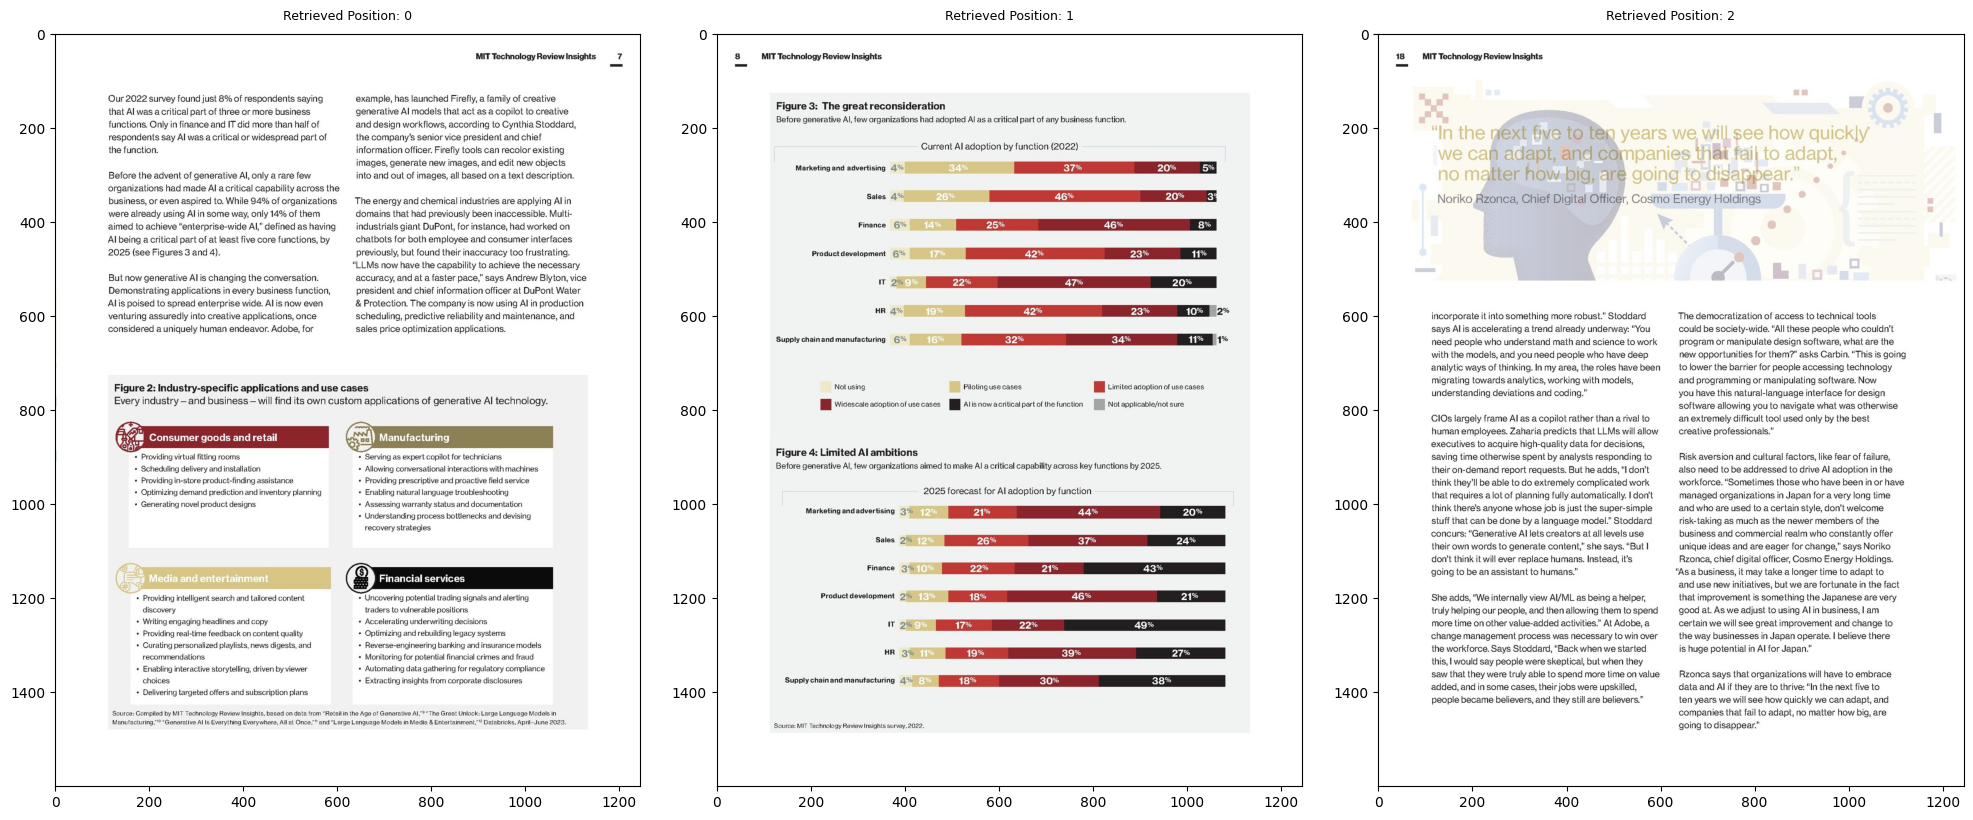

Response: Based on the 2022 survey, only 8% of respondents found AI to be a critical part of three or more business functions. This information is derived from the parsed markdown text provided for page 7. The relevant excerpt is:

> "Our 2022 survey found just 8% of respondents saying that AI was a critical part of three or more business functions."

This percentage is also visually supported by the image of page 7, which contains the same information. There are no discrepancies between the parsed markdown text and the image.


Source Nodes:

Page Number: 7
Text Content Length: 3776

Page Number: 8
Text Content Length: 4065

Page Number: 18
Text Content Length: 3365


In [123]:
# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))